In [2]:
import os
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
import cv2
import wandb

/home/vera/miniconda3/envs/ails/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load jpeg images from a directory and convert them to numpy arrays
def load_images(directory):
    images = []
    for filename in glob.glob(directory + '/*.jpg'):
        img = Image.open(filename)
        img = np.array(img)
        images.append(img)
    return np.array(images)



def points_out_of_graph(data_embedded, data, x_axis_threshold, y_axis_theshold, x_over=True, y_over=True):
    if x_over:
        if y_over:
            indices = np.where((data_embedded[:, 0] > x_axis_threshold) & (data_embedded[:, 1] > y_axis_theshold))[0]
        else:
            indices = np.where((data_embedded[:, 0] > x_axis_threshold) & (data_embedded[:, 1] < y_axis_theshold))[0]
    else:
        if y_over:
            indices = np.where((data_embedded[:, 0] < x_axis_threshold) & (data_embedded[:, 1] > y_axis_theshold))[0]
        else:
            indices = np.where(data_embedded[:, 0] < x_axis_threshold)[0] & (data_embedded[:, 1] < y_axis_theshold)[0]


    points = data[indices]

    print(f"There are {len(points)} points\n")
    print(f"Indices of the points are: {indices}\n")
    return indices

def analyze_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue, saturation, value = cv2.split(hsv_image)
    
    # Chroma is defined as the difference between the maximum and minimum RGB values
    r, g, b = cv2.split(image)
    chroma = np.maximum(np.maximum(r, g), b) - np.minimum(np.minimum(r, g), b)
    
    return hue, saturation, chroma


In [18]:
data_path = "/home/vera/Documents/AI/AILS-MICCAI-UWF4DR-Challenge/data/raw/UWF4DRChallengeData/Task 1 Image Quality Assessment/1. Images/1. Training"
data = load_images(data_path)


In [4]:
n_samples, h, w, c = data.shape
flattened_images = data.reshape(n_samples, -1)

# Standardize the data
scaler = StandardScaler()
flattened_images_scaled = scaler.fit_transform(flattened_images)

# Apply PCA
n_components = 2  # Number of principal components to keep
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_scaled)

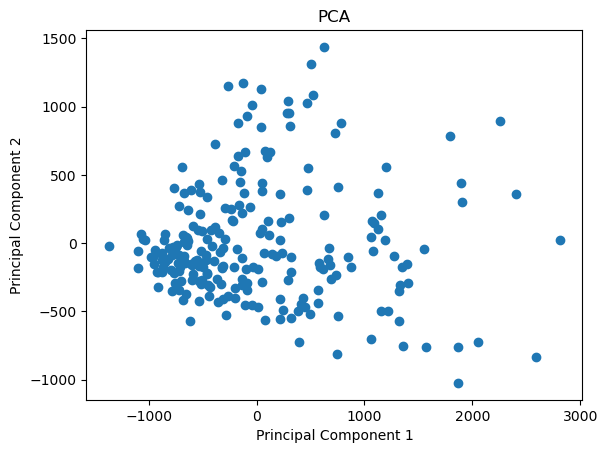

In [5]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

In [6]:
points_out_of_graph(principal_components, data, 2000, -1000, x_over=True, y_over=True)

There are 5 points

Indices of the points are: [ 35  52  83 149 220]



array([ 35,  52,  83, 149, 220])

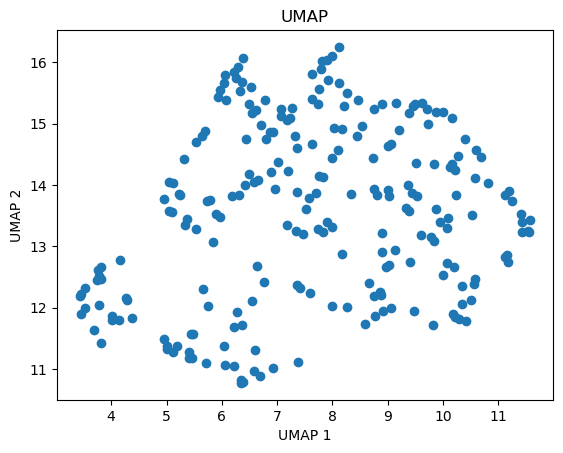

In [7]:
umap_model = umap.UMAP(n_components=2, n_neighbors=5)
umap_embedding = umap_model.fit_transform(flattened_images_scaled)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP')
plt.show()


In [14]:
indices = points_out_of_graph(umap_embedding, data, 4.9, 0, x_over=False, y_over=True)


There are 20 points

Indices of the points are: [  5  19  33  36  43  44  51  55  65  99 103 113 120 125 138 151 168 187
 196 218]



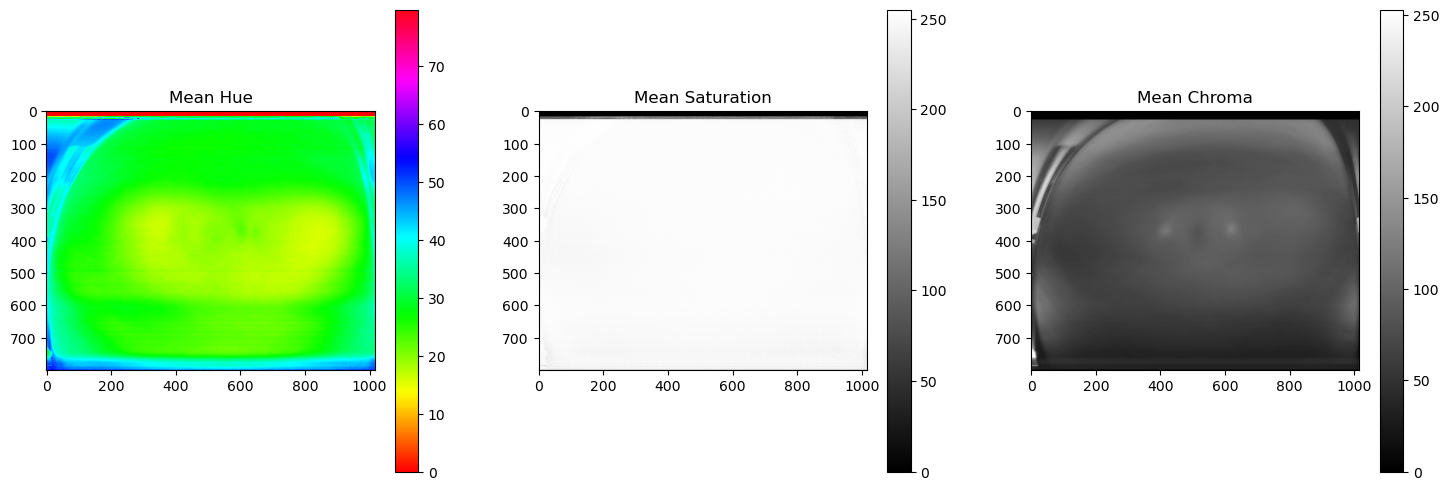

In [9]:


# Initialize lists to hold the extracted components
hue_list = []
saturation_list = []
chroma_list = []

# Process each image
for img in data:
    hue, saturation, chroma = analyze_hsv(img)
    hue_list.append(hue)
    saturation_list.append(saturation)
    chroma_list.append(chroma)

# Convert lists to numpy arrays for further analysis
hue_array = np.array(hue_list)
saturation_array = np.array(saturation_list)
chroma_array = np.array(chroma_list)

#plot the mean hue, saturation, and chroma
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.mean(hue_array, axis=0), cmap='hsv')
plt.title('Mean Hue')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.mean(saturation_array, axis=0), cmap='gray')
plt.title('Mean Saturation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.mean(chroma_array, axis=0), cmap='gray')
plt.title('Mean Chroma')
plt.colorbar()

plt.show()



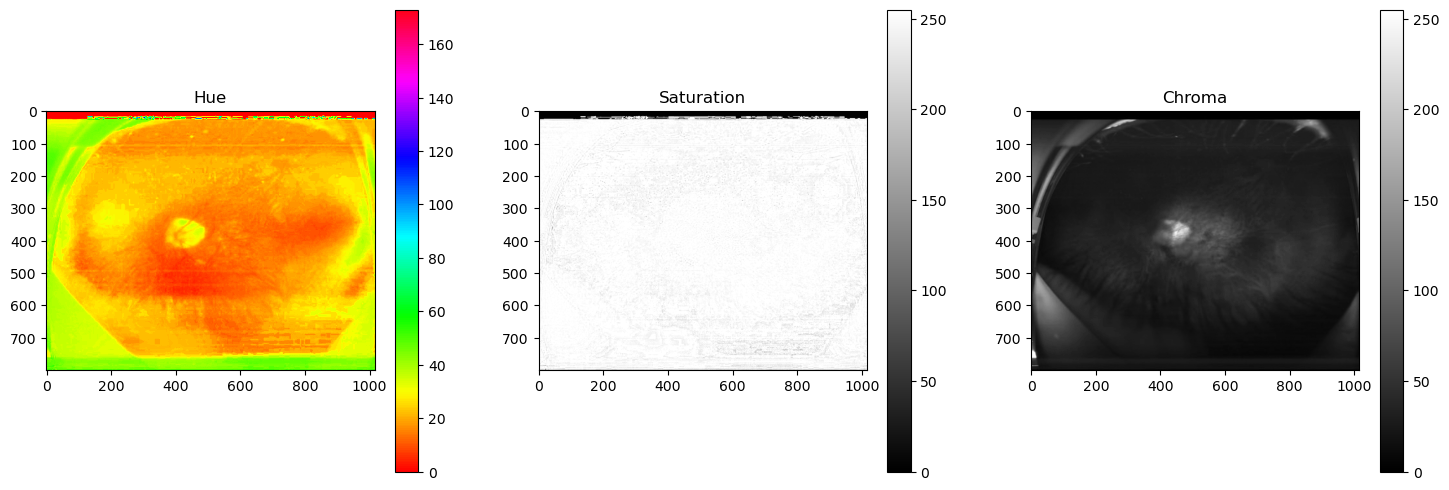

In [10]:

# Visualize the average hue, saturation, and chroma for the first image as an example
example_index = 0
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(hue_array[example_index], cmap='hsv')
plt.title('Hue')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(saturation_array[example_index], cmap='gray')
plt.title('Saturation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(chroma_array[example_index], cmap='gray')
plt.title('Chroma')
plt.colorbar()

plt.show()


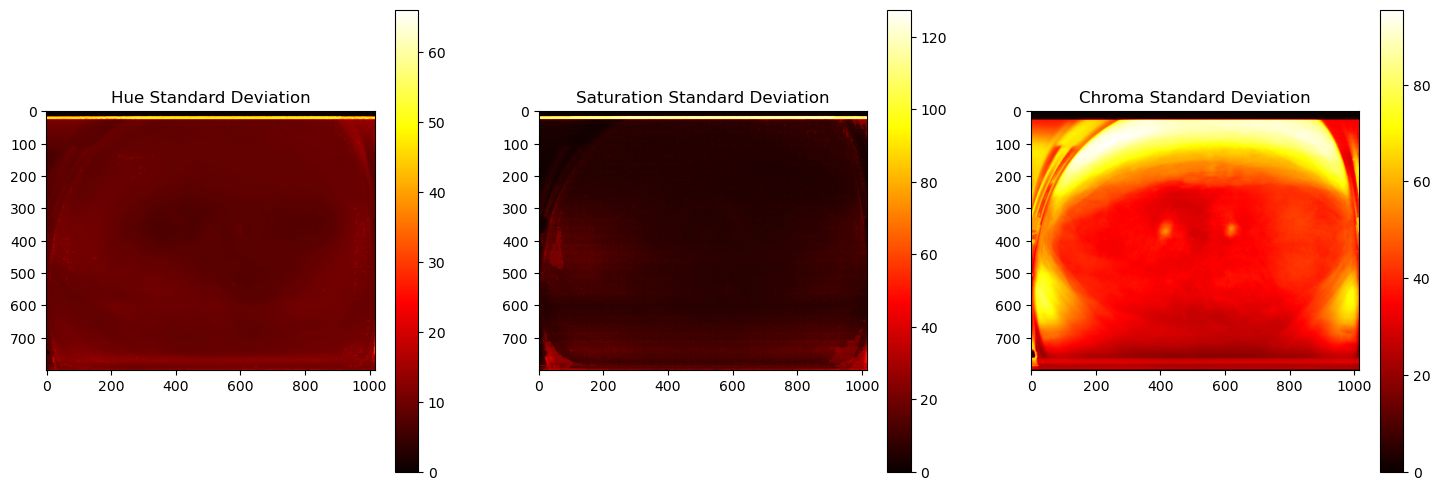

In [11]:
hue_std = np.std(hue_array, axis=0)
saturation_std = np.std(saturation_array, axis=0)
chroma_std = np.std(chroma_array, axis=0)

# Plot the standard deviation maps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(hue_std, cmap='hot')
plt.title('Hue Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(saturation_std, cmap='hot')
plt.title('Saturation Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(chroma_std, cmap='hot')
plt.title('Chroma Standard Deviation')
plt.colorbar()

plt.show()


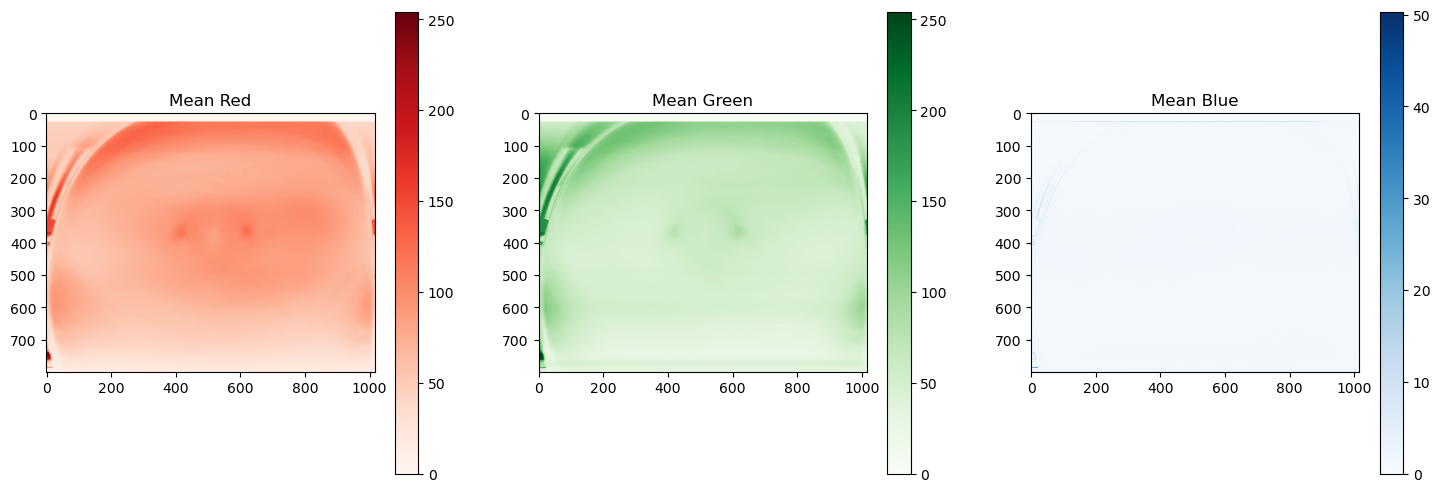

In [12]:
red_list = []
green_list = []
blue_list = []

# Process each image
for img in data:
    red, green, blue = cv2.split(img)
    red_list.append(red)
    green_list.append(green)
    blue_list.append(blue)

red_array = np.array(red_list)
green_array = np.array(green_list)
blue_array = np.array(blue_list)


plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.mean(red_array, axis=0), cmap='Reds')
plt.title('Mean Red')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.mean(green_array, axis=0), cmap='Greens')
plt.title('Mean Green')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.mean(blue_array, axis=0), cmap='Blues')
plt.title('Mean Blue')
plt.colorbar()

plt.show()


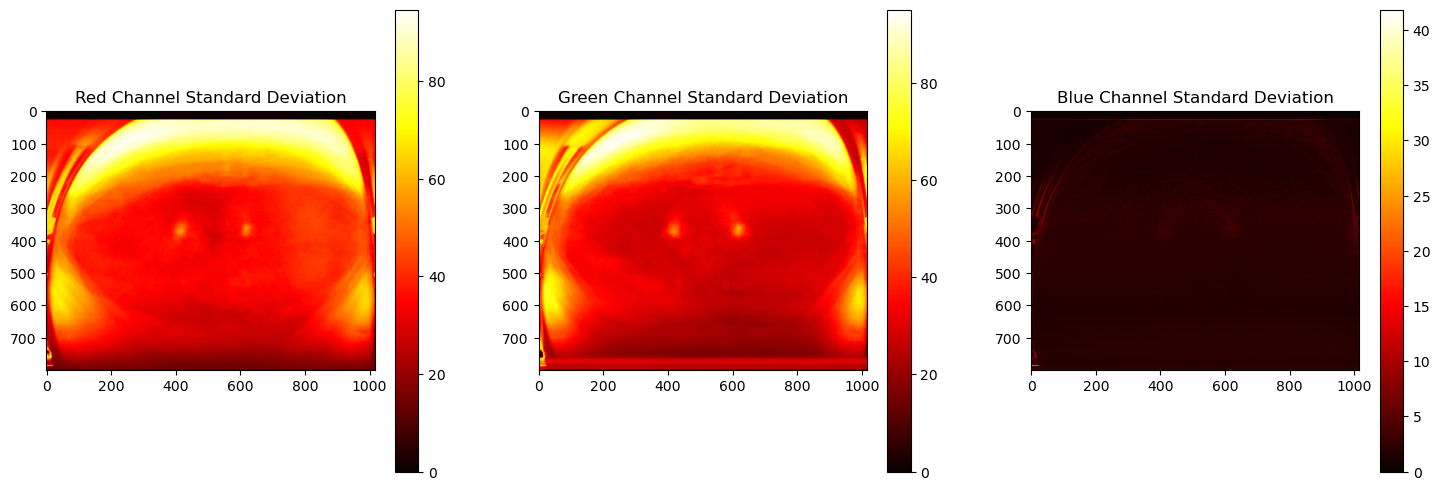

In [13]:

# Plot the standard deviation maps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(np.std(red_array, axis=0), cmap='hot')
plt.title('Red Channel Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.std(green_array, axis=0), cmap='hot')
plt.title('Green Channel Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.std(blue_array, axis=0), cmap='hot')
plt.title('Blue Channel Standard Deviation')
plt.colorbar()

plt.show()

In [35]:

label_path = "/home/vera/Documents/AI/AILS-MICCAI-UWF4DR-Challenge/data/raw/UWF4DRChallengeData/Task 1 Image Quality Assessment/2. Groundtruths/1. Training.csv"
# Create a binary classification task with an SVM
y = np.loadtxt(label_path, delimiter=',', skiprows=1, usecols=1)
y = y[:233]
# many more 0 (250) than 1 (28)

28

In [26]:
# perform a SVM classification on the data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



(233,)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_scaled, y, test_size=0.2, random_state=42)

In [29]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [30]:
from sklearn.metrics import classification_report, accuracy_score
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Print the classification report and accuracy
print(classification_report(y_pred, y_test))
print("Accuracy:", accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93        46
         1.0       0.00      0.00      0.00         1

    accuracy                           0.87        47
   macro avg       0.49      0.45      0.47        47
weighted avg       0.96      0.87      0.91        47

Accuracy: 0.8723404255319149


In [33]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]



              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93        42
         1.0       0.00      0.00      0.00         5

    accuracy                           0.87        47
   macro avg       0.45      0.49      0.47        47
weighted avg       0.80      0.87      0.83        47

Accuracy: 0.8723404255319149


NameError: name 'roc_auc_score' is not defined

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93        42
         1.0       0.00      0.00      0.00         5

    accuracy                           0.87        47
   macro avg       0.45      0.49      0.47        47
weighted avg       0.80      0.87      0.83        47

Accuracy: 0.8723404255319149
AUROC: 0.6714285714285715
AUPRC: 0.14033396840517584
Sensitivity: 0.0
Specificity: 0.9761904761904762


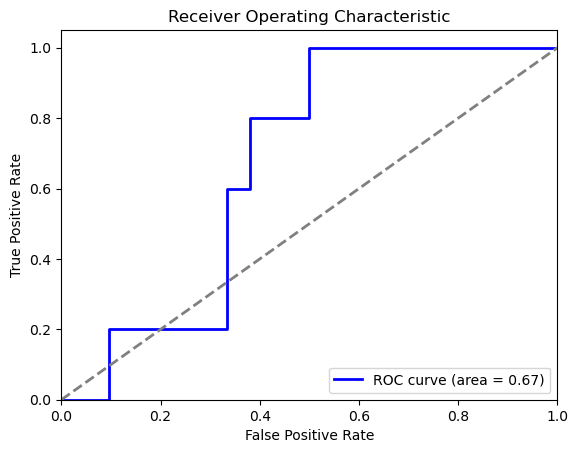

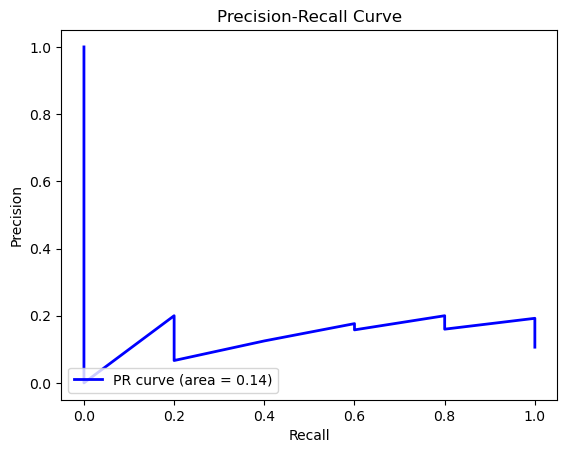

In [34]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix

# Classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate AUROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUROC:", roc_auc)

# Calculate AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Calculate sensitivity and specificity
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [7]:
wandb.init(project="UWF4DR_Challenge", entity="pilsvera", name = "training")

KeyboardInterrupt: 